In [1]:
import os
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tpot import TPOTRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

In [2]:
API_TOKEN = '9b26b5d5fc3c3cd3bd0aca58d14a871215020ff3'
df_oil_prod = pd.read_csv(
	f'https://www.econdb.com/api/series/OILPRODUS/?format=csv&token={API_TOKEN}',
	index_col='Date', parse_dates=['Date'])

df_oil_prod

,OILPRODUS
Date,
2002-01-01,5848
2002-02-01,5871
2002-03-01,5883
2002-04-01,5859
2002-05-01,5924
...,...
2023-05-01,12694
2023-06-01,12894
2023-07-01,12959


In [3]:
df_oil_prod.head()

,OILPRODUS
Date,
2002-01-01,5848
2002-02-01,5871
2002-03-01,5883
2002-04-01,5859
2002-05-01,5924


In [4]:
df_oil_prod.to_csv('oilProd.csv', index=False)

In [5]:
# Create a reference date range with monthly frequency and start of the month
expected_dates_start = pd.date_range(start=df_oil_prod.index.min(), end=df_oil_prod.index.max(), freq='MS')

# Find the dates that are missing in the actual data
missing_dates_start = expected_dates_start.difference(df_oil_prod.index)

# Display the missing dates or a message if there are none
if not missing_dates_start.empty:
    print("Dates with Missing Months (Start of the Month):")
    print(missing_dates_start)
else:
    print("No missing months found.")

No missing months found.


In [6]:
# Check for missing values in the 'OILPRODUS' column
missing_values = df_oil_prod['OILPRODUS'].isnull().any()

# Display the result
if missing_values:
    print("There are missing values in the 'OILPRODUS' column.")
else:
    print("No missing values found in the 'OILPRODUS' column.")

No missing values found in the 'OILPRODUS' column.


In [7]:
# Check for missing values or 0 values in the 'OILPRODUS' column
missing_or_zero_values = (df_oil_prod['OILPRODUS'].isnull() | (df_oil_prod['OILPRODUS'] == 0)).any()

# Display the result
if missing_or_zero_values:
    print("There are missing or 0 values in the 'OILPRODUS' column.")
else:
    print("No missing or 0 values found in the 'OILPRODUS' column.")

No missing or 0 values found in the 'OILPRODUS' column.


Summary Statistics:
          OILPRODUS
count    261.000000
mean    7884.103448
std     2730.388830
min     3974.000000
25%     5440.000000
50%     7082.000000
75%    10262.000000
max    13053.000000


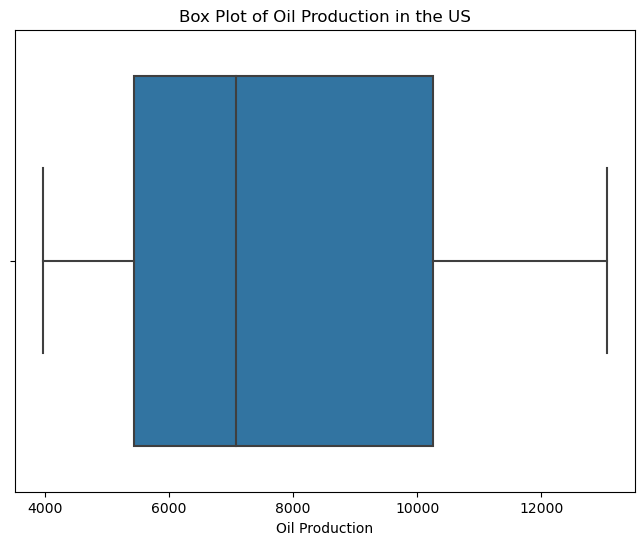

In [8]:
# Display basic statistics of the dataset
print("Summary Statistics:")
print(df_oil_prod.describe())

# Create a box plot for 'OILPRODUS'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_oil_prod['OILPRODUS'])
plt.title('Box Plot of Oil Production in the US')
plt.xlabel('Oil Production')
plt.show()

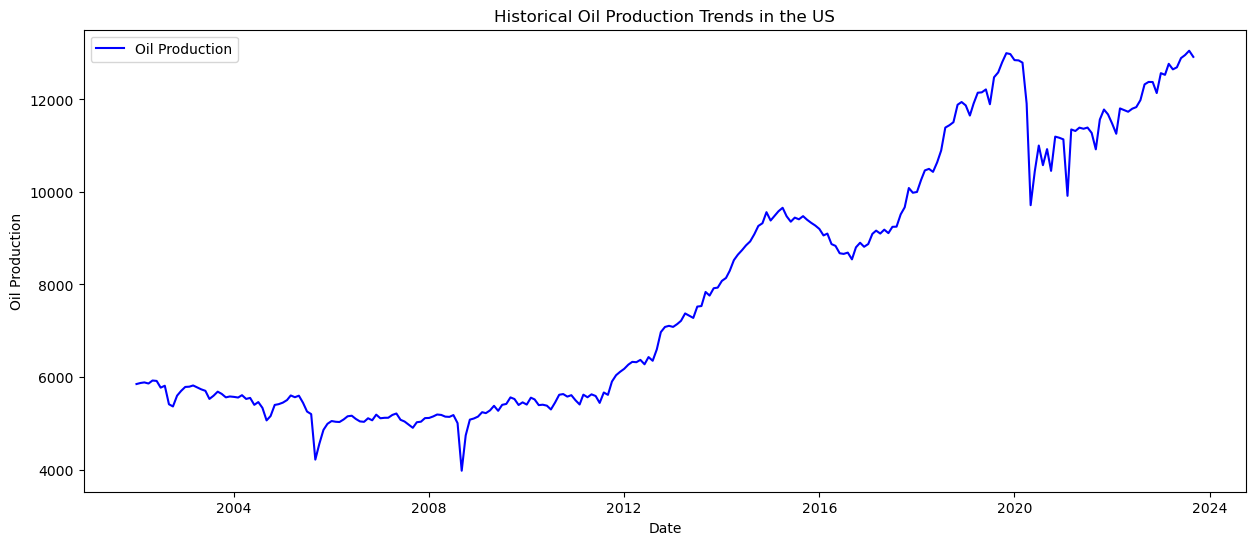

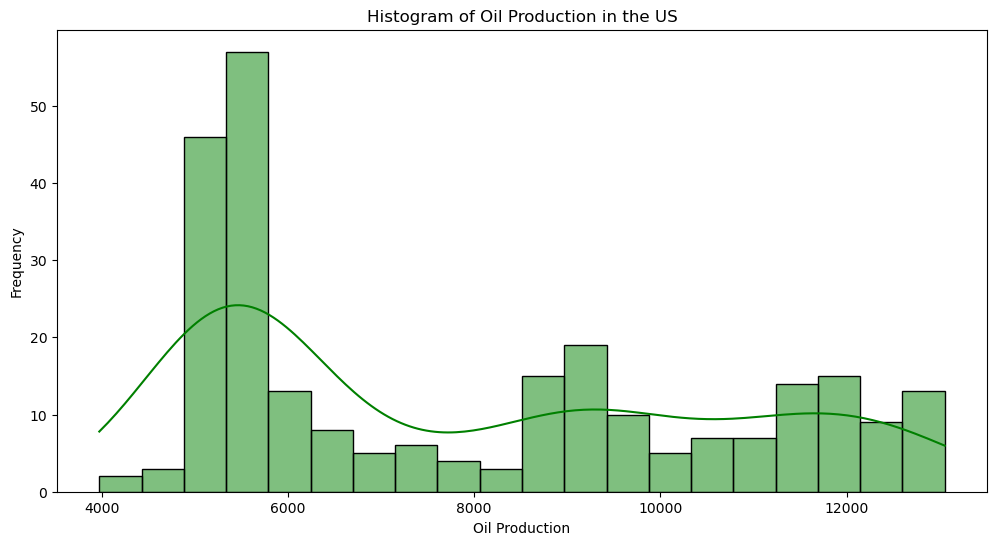

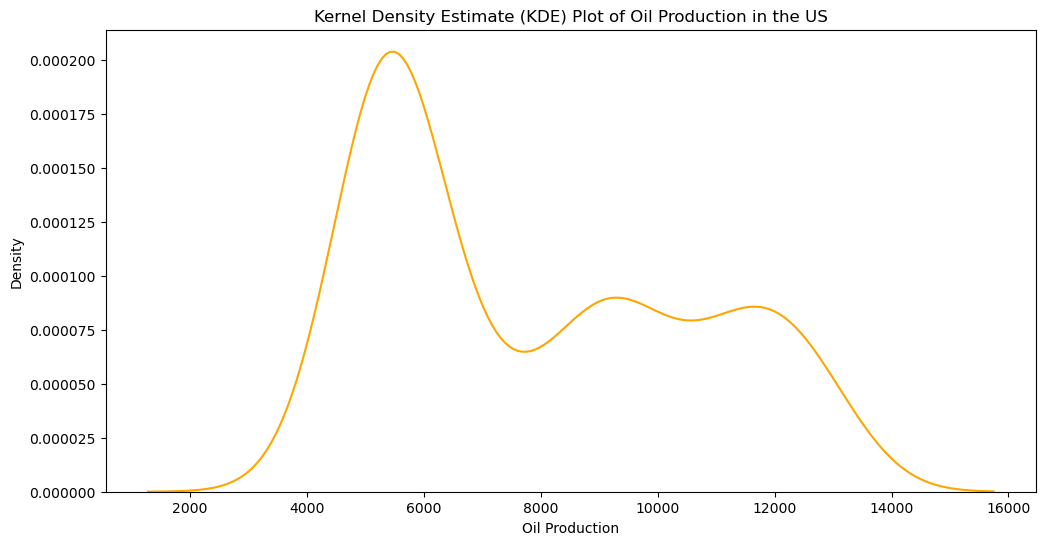

In [9]:
# Line chart for historical oil production trends
plt.figure(figsize=(15, 6))
plt.plot(df_oil_prod.index, df_oil_prod['OILPRODUS'], label='Oil Production', color='blue')
plt.title('Historical Oil Production Trends in the US')
plt.xlabel('Date')
plt.ylabel('Oil Production')
plt.legend()
plt.show()

# Histogram of oil production
plt.figure(figsize=(12, 6))
sns.histplot(df_oil_prod['OILPRODUS'], bins=20, kde=True, color='green')
plt.title('Histogram of Oil Production in the US')
plt.xlabel('Oil Production')
plt.ylabel('Frequency')
plt.show()

# KDE plot of oil production
plt.figure(figsize=(12, 6))
sns.kdeplot(df_oil_prod['OILPRODUS'], color='orange')
plt.title('Kernel Density Estimate (KDE) Plot of Oil Production in the US')
plt.xlabel('Oil Production')
plt.ylabel('Density')
plt.show()

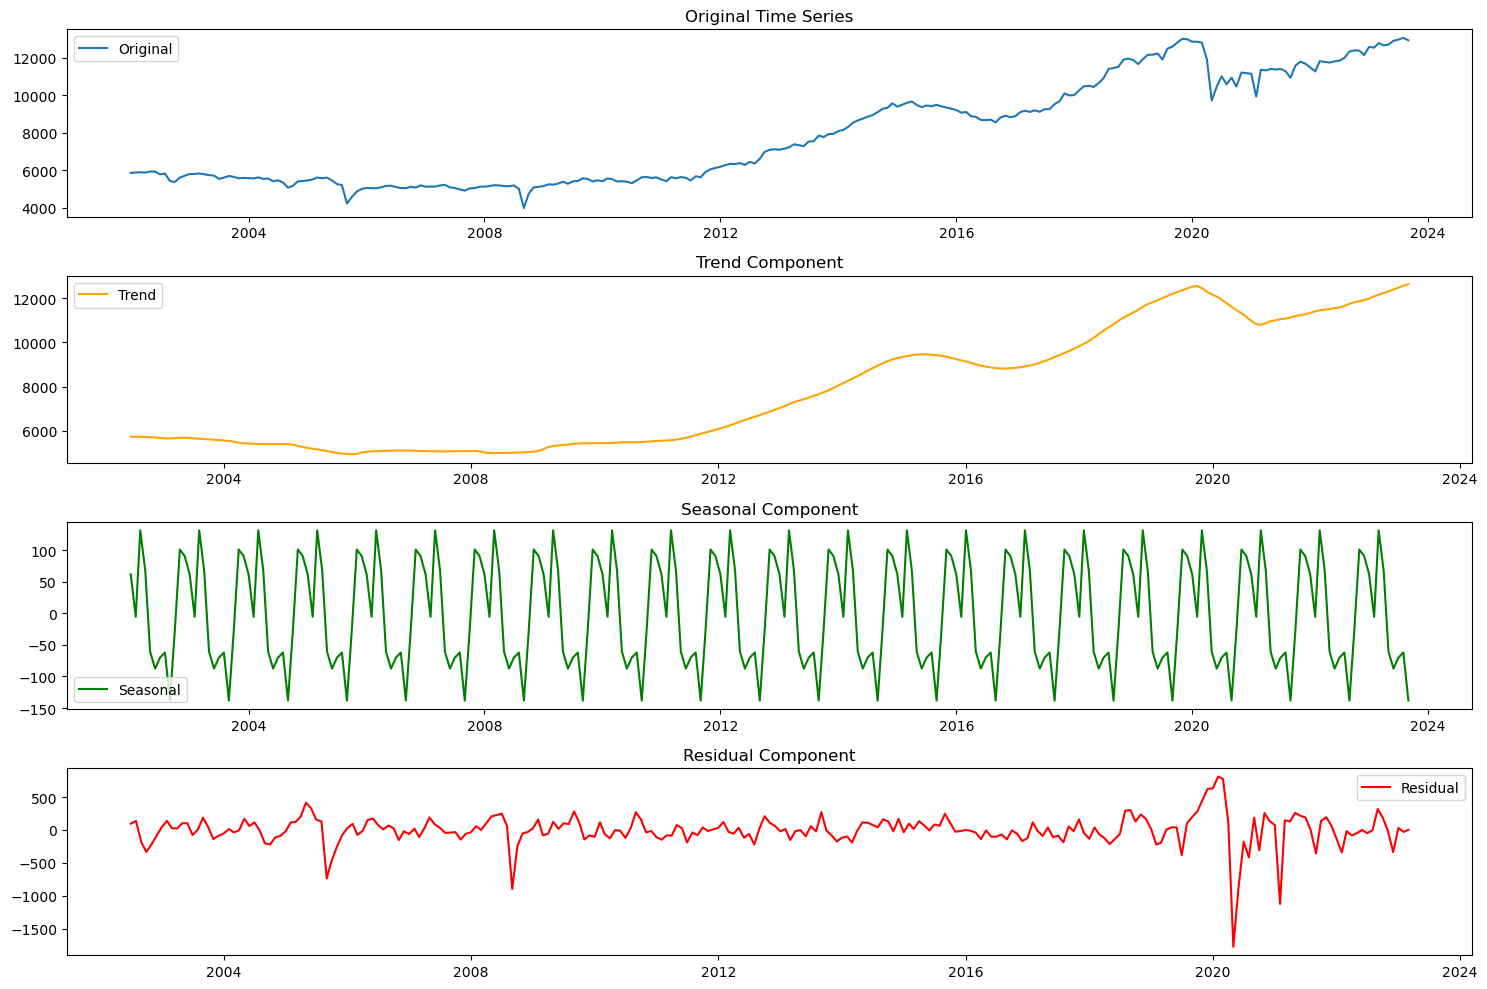

In [10]:
# Perform seasonal decomposition
result = seasonal_decompose(df_oil_prod['OILPRODUS'], model='additive', period=12)  # Assuming a monthly seasonality

# Plot the decomposed components
plt.figure(figsize=(15, 10))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(df_oil_prod.index, df_oil_prod['OILPRODUS'], label='Original')
plt.legend()
plt.title('Original Time Series')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend()
plt.title('Trend Component')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend()
plt.title('Seasonal Component')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red')
plt.legend()
plt.title('Residual Component')

plt.tight_layout()
plt.show()

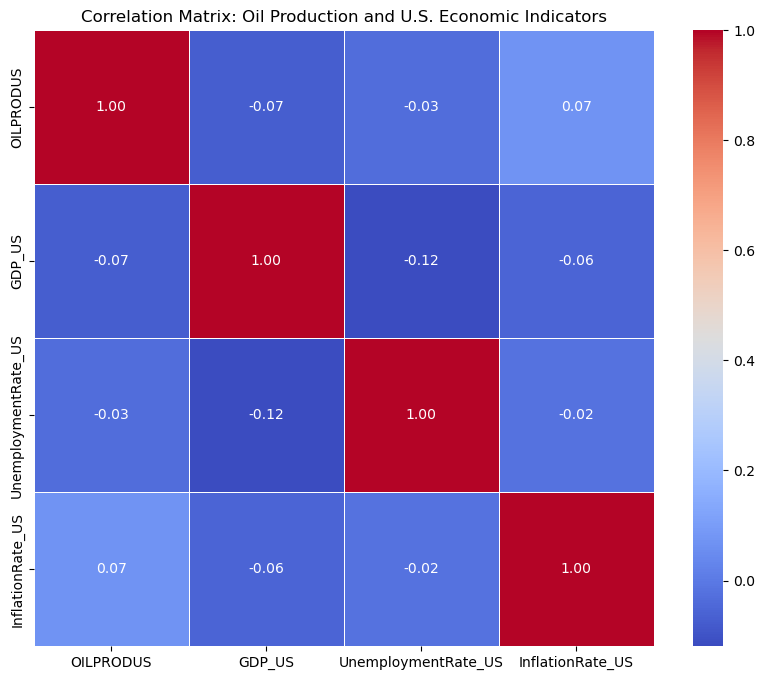

In [11]:
# Create hypothetical economic data for the United States
dates = pd.date_range(start='2002-01-01', end='2023-09-01', freq='MS')
economic_data_us = {
    'Date': dates,
    'GDP_US': np.random.randn(len(dates)),
    'UnemploymentRate_US': np.random.randn(len(dates)),
    'InflationRate_US': np.random.randn(len(dates))
}

df_economic_us = pd.DataFrame(economic_data_us)

# Merge the oil production data with U.S. economic indicators on the common 'Date' column
df_merged_us = pd.merge(df_oil_prod, df_economic_us, on='Date', how='inner')

# Calculate correlations
correlation_matrix_us = df_merged_us.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_us, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix: Oil Production and U.S. Economic Indicators')
plt.show()

In [12]:
df_economic_us

,Date,GDP_US,UnemploymentRate_US,InflationRate_US
0,2002-01-01,0.927220,-0.774141,1.540700
1,2002-02-01,0.619846,0.036108,-1.113049
2,2002-03-01,0.116571,1.620758,0.252902
3,2002-04-01,-1.590787,0.878886,1.062976
4,2002-05-01,0.393761,-0.990828,1.518637
...,...,...,...,...
256,2023-05-01,0.072216,0.761302,1.270078
257,2023-06-01,0.010599,0.039696,0.391829
258,2023-07-01,-1.742772,-0.962738,-0.861123
259,2023-08-01,-0.378892,-0.060647,1.787539


In [13]:
# Create lag features for oil production (e.g., lagged values for the past 3 months)
for i in range(1, 4):
    df_oil_prod[f'OILPRODUS_Lag{i}'] = df_oil_prod['OILPRODUS'].shift(i)

# Merge with economic indicators for the United States
df_combined = pd.merge(df_oil_prod, df_economic_us, on='Date', how='left')

# Create additional features based on economic indicators
df_combined['EconomicImpact'] = df_combined['GDP_US'] * df_combined['InflationRate_US']
df_combined['UnemploymentRateSquared'] = df_combined['UnemploymentRate_US'] ** 2

# Display the updated DataFrame with new features
print(df_combined.head())

        Date  OILPRODUS  OILPRODUS_Lag1  OILPRODUS_Lag2  OILPRODUS_Lag3  \
0 2002-01-01       5848             NaN             NaN             NaN   
1 2002-02-01       5871          5848.0             NaN             NaN   
2 2002-03-01       5883          5871.0          5848.0             NaN   
3 2002-04-01       5859          5883.0          5871.0          5848.0   
4 2002-05-01       5924          5859.0          5883.0          5871.0   

     GDP_US  UnemploymentRate_US  InflationRate_US  EconomicImpact  \
0  0.927220            -0.774141          1.540700        1.428568   
1  0.619846             0.036108         -1.113049       -0.689918   
2  0.116571             1.620758          0.252902        0.029481   
3 -1.590787             0.878886          1.062976       -1.690968   
4  0.393761            -0.990828          1.518637        0.597981   

   UnemploymentRateSquared  
0                 0.599294  
1                 0.001304  
2                 2.626857  
3           

Mean Absolute Percentage Error (MAPE): 17.04%


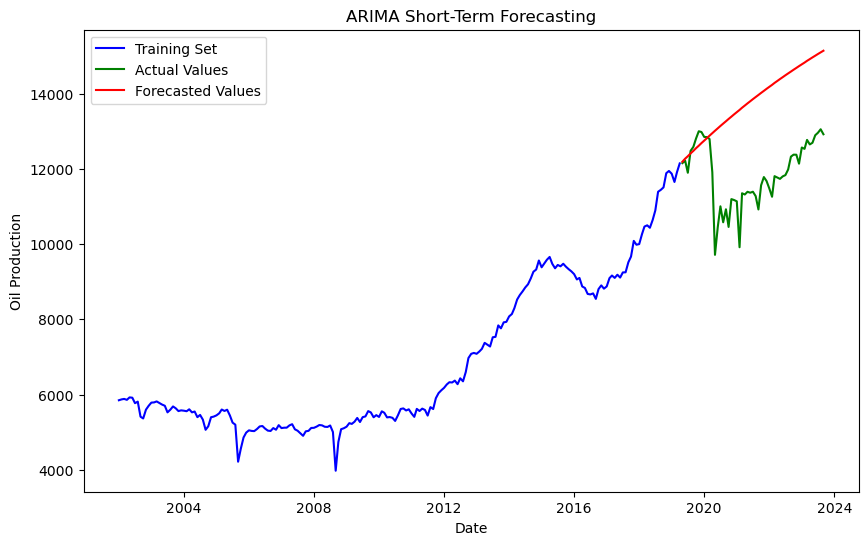

In [14]:
# Select relevant columns and set 'Date' as the index
df_forecast = df_combined[['Date', 'OILPRODUS']].set_index('Date')

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df_forecast) * 0.8)
train, test = df_forecast[:train_size], df_forecast[train_size:]

# Train the ARIMA model with adjusted parameters
order = (3, 1, 2)  # Adjust these values based on experimentation
model = ARIMA(train, order=order)
fit_model = model.fit()

# Validate the model using the testing set
forecast = fit_model.forecast(steps=len(test))

# Make sure that both test and forecast are in a format that supports element-wise operations
test_values = test.squeeze()  # This converts the test DataFrame or Series to a NumPy array
forecast_values = forecast.squeeze()  # Similarly for forecast

# Calculate MAPE, handling cases where test values are zero
mape = np.mean(np.abs((test_values - forecast_values) / test_values)) * 100 if np.any(test_values != 0) else float('inf')

# Print evaluation metrics
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot the actual vs. forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Set', color='blue')
plt.plot(test.index, test, label='Actual Values', color='green')
plt.plot(test.index, forecast, label='Forecasted Values', color='red')
plt.title('ARIMA Short-Term Forecasting')
plt.xlabel('Date')
plt.ylabel('Oil Production')
plt.legend()
plt.show()

In [15]:
# Define your features (X) and target variable (y)
X = df_oil_prod.drop('OILPRODUS', axis=1)
y = df_oil_prod['OILPRODUS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TPOT
tpot = TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2, n_jobs=-1, max_time_mins=30, memory='auto')

# Fit the TPOT model
tpot.fit(X_train, y_train)

# Evaluate the best pipeline on the testing set
y_pred = tpot.predict(X_test)

# Evaluation metrics
mae_tpot = mean_absolute_error(y_test, y_pred)
rmse_tpot = sqrt(mean_squared_error(y_test, y_pred))

# Calculate MAPE
mape_tpot = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 if np.any(y_test != 0) else float('inf')

# Print evaluation metrics for TPOT
print(f'TPOT Mean Absolute Percentage Error (MAPE): {mape_tpot:.2f}%')

# Export the best pipeline if needed
tpot.export('best_model_pipeline.py')

Imputing missing values in feature set


Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -83782.79912013323

Generation 2 - Current best internal CV score: -83782.79912013323

Generation 3 - Current best internal CV score: -83781.16711039223

Generation 4 - Current best internal CV score: -83769.44081797656

Generation 5 - Current best internal CV score: -83571.59252630915

Best pipeline: ElasticNetCV(input_matrix, l1_ratio=0.8500000000000001, tol=0.1)
Imputing missing values in feature set
TPOT Mean Absolute Percentage Error (MAPE): 2.07%


In [16]:
# Impute missing values in the feature set
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the imputed data into training and testing sets
X_train_imp, X_test_imp, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Initialize the ElasticNetCV model
elastic_net_model = ElasticNetCV(l1_ratio=0.15000000000000002, tol=0.1)

# Fit the model on the training set
elastic_net_model.fit(X_train_imp, y_train)

# Predict on the testing set
y_pred_elastic_net = elastic_net_model.predict(X_test_imp)

# Evaluation metrics
mae_elastic_net = mean_absolute_error(y_test, y_pred_elastic_net)
rmse_elastic_net = sqrt(mean_squared_error(y_test, y_pred_elastic_net))

# Calculate MAPE
mape_elastic_net = np.mean(np.abs((y_test - y_pred_elastic_net) / y_test)) * 100 if np.any(y_test != 0) else float('inf')

# Print evaluation metrics for ElasticNetCV
print(f'ElasticNetCV Mean Absolute Percentage Error (MAPE): {mape_elastic_net:.2f}%')

ElasticNetCV Mean Absolute Percentage Error (MAPE): 2.06%


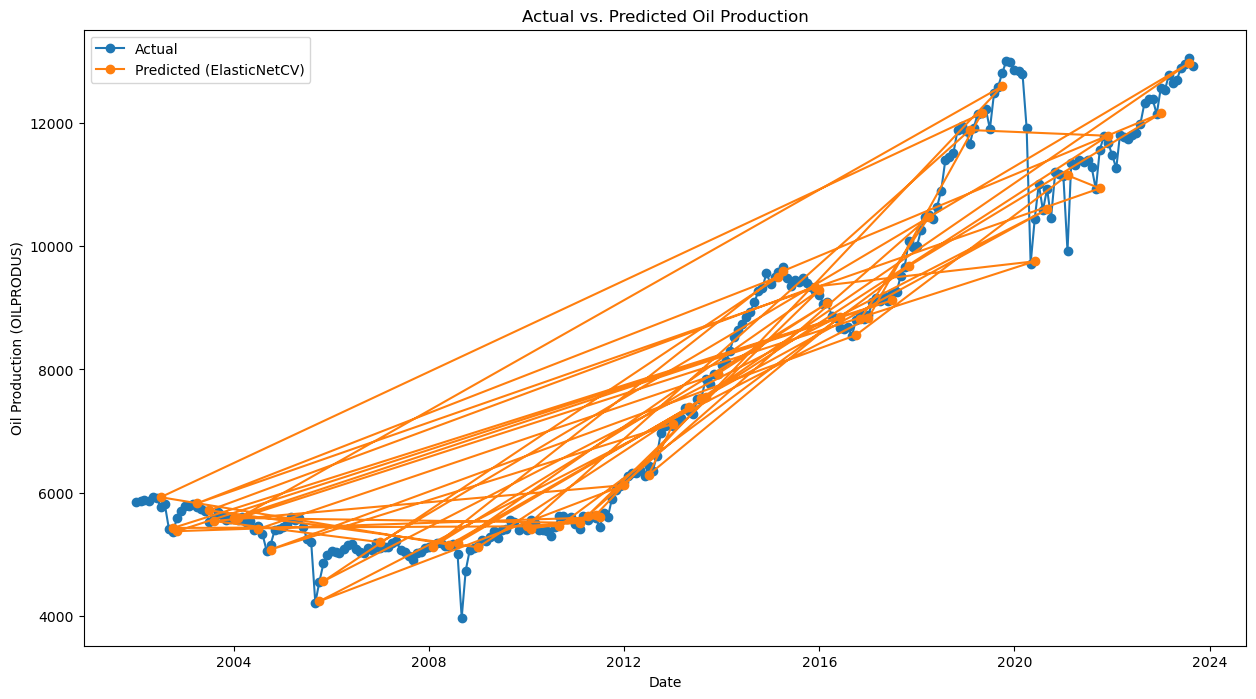

ElasticNetCV Mean Absolute Percentage Error (MAPE): 2.06%


In [17]:
#Plotting actual vs. predicted values for all years
plt.figure(figsize=(15, 8))

# Plot actual oil production values
plt.plot(y.index, y, label='Actual', marker='o')

# Plot predicted values for the test set
plt.plot(y_test.index, y_pred_elastic_net, label='Predicted (ElasticNetCV)', marker='o')

plt.title('Actual vs. Predicted Oil Production')
plt.xlabel('Date')
plt.ylabel('Oil Production (OILPRODUS)')
plt.legend()
plt.show()

# Print evaluation metrics for ElasticNetCV
print(f'ElasticNetCV Mean Absolute Percentage Error (MAPE): {mape_elastic_net:.2f}%')


Epoch 1/50
6/6 - 2s - loss: 0.0938 - val_loss: 0.4895 - 2s/epoch - 254ms/step
Epoch 2/50
6/6 - 0s - loss: 0.0706 - val_loss: 0.3934 - 44ms/epoch - 7ms/step
Epoch 3/50
6/6 - 0s - loss: 0.0525 - val_loss: 0.3090 - 47ms/epoch - 8ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0379 - val_loss: 0.2305 - 56ms/epoch - 9ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0238 - val_loss: 0.1539 - 59ms/epoch - 10ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0132 - val_loss: 0.0838 - 51ms/epoch - 8ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0090 - val_loss: 0.0326 - 49ms/epoch - 8ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0090 - val_loss: 0.0174 - 44ms/epoch - 7ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0074 - val_loss: 0.0243 - 60ms/epoch - 10ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0054 - val_loss: 0.0314 - 54ms/epoch - 9ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0044 - val_loss: 0.0178 - 52ms/epoch - 9ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0028 - val_loss: 0.0055 - 50ms/epoch - 8ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0020 - val_loss: 0.0024 - 49

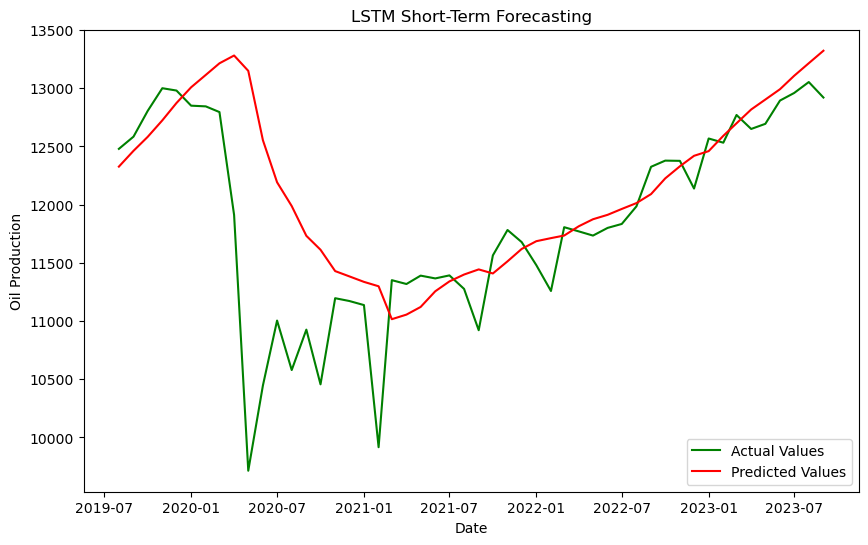

In [18]:
# Use 'OILPRODUS' column as the target variable
target_variable = 'OILPRODUS'

# Extract the target variable
y = df_oil_prod[target_variable].values.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

# Function to create sequences for LSTM
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Set the time steps for LSTM
time_steps = 12  # You can adjust this based on the data

# Create sequences for LSTM
X, y = create_sequences(y_scaled, time_steps)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape the input data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=2)

# Predict on the testing set
y_pred_lstm = model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the performance of the LSTM model
mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm)
rmse_lstm = sqrt(mean_squared_error(y_test_actual, y_pred_lstm))
mape_lstm = np.mean(np.abs((y_test_actual - y_pred_lstm) / y_test_actual)) * 100

# Print evaluation metrics for LSTM
print(f'LSTM Mean Absolute Percentage Error (MAPE): {mape_lstm:.2f}%')

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_oil_prod.index[-len(y_test_actual):], y_test_actual, label='Actual Values', color='green')
plt.plot(df_oil_prod.index[-len(y_pred_lstm):], y_pred_lstm, label='Predicted Values', color='red')
plt.title('LSTM Short-Term Forecasting')
plt.xlabel('Date')
plt.ylabel('Oil Production')
plt.legend()
plt.show()


XGBoost Mean Absolute Percentage Error (MAPE): 17.48%


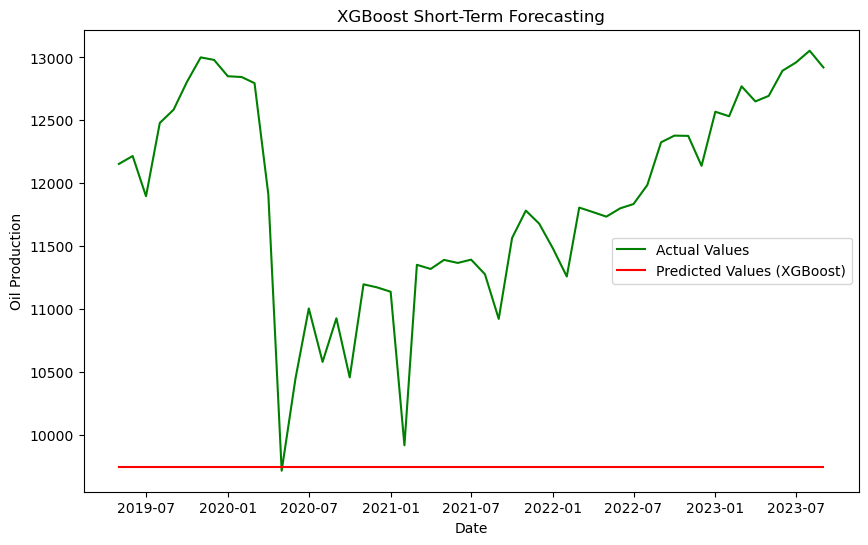

In [19]:

# Select relevant columns and set 'Date' as the index
df_forecast = df_combined[['Date', 'OILPRODUS']].set_index('Date')

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df_forecast) * 0.8)
train, test = df_forecast[:train_size], df_forecast[train_size:]

# Extract features and target variable
X_train, y_train = train.index.astype(int).values.reshape(-1, 1), train['OILPRODUS'].values
X_test, y_test = test.index.astype(int).values.reshape(-1, 1), test['OILPRODUS'].values

# Initialize XGBoost model
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Train the XGBoost model
model.fit(X_train, y_train)

# Validate the model using the testing set
y_pred_xgboost = model.predict(X_test)

# Evaluate the performance of the model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
rmse_xgboost = sqrt(mean_squared_error(y_test, y_pred_xgboost))
mape_xgboost = np.mean(np.abs((y_test - y_pred_xgboost) / y_test)) * 100

# Print evaluation metrics for XGBoost
print(f'XGBoost Mean Absolute Percentage Error (MAPE): {mape_xgboost:.2f}%')

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test, label='Actual Values', color='green')
plt.plot(test.index, y_pred_xgboost, label='Predicted Values (XGBoost)', color='red')
plt.title('XGBoost Short-Term Forecasting')
plt.xlabel('Date')
plt.ylabel('Oil Production')
plt.legend()
plt.show()


In [20]:
##
# Prepare X_last for ElasticNetCV
X_last = df_oil_prod.drop('OILPRODUS', axis=1).iloc[-1].values.reshape(1, -1)

# Prepare y_last for ARIMA
y_last = df_forecast['OILPRODUS'].iloc[-1:]

# Assuming you have already defined and trained 'elastic_net_model', 'fit_model', 'model', and 'y_scaled'

n_months = 60
def forecast_oil_production_ensemble(n_months, elastic_net_model, fit_model, X_last, y_last):
    """
    Forecast oil production using an ensemble of ElasticNet and ARIMA models.

    Parameters:
    n_months (int): Number of months to forecast.
    elastic_net_model: Trained ElasticNet model.
    arima_model: Trained ARIMA model.
    X_last: The last observed data point for ElasticNet.
    y_last: The last observed data point for ARIMA.

    Returns:
    DataFrame: A DataFrame with forecasted values for the specified number of months.
    """
    # Prepare future dates
    future_dates = pd.date_range(start=y_last.index[-1] + pd.DateOffset(months=1), periods=n_months, freq='M')

    # ElasticNet prediction
    elastic_net_preds = elastic_net_model.predict(X_last)

    # ARIMA prediction
    arima_preds = fit_model.forecast(steps=n_months)

    # Ensemble prediction (average of the two model predictions)
    ensemble_preds = (elastic_net_preds + arima_preds) / 2

    # Creating a DataFrame for the forecasted values
    forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted Oil Production': ensemble_preds})
    
    return forecast_df

# Call the function without the LSTM model
forecast_df = forecast_oil_production_ensemble(n_months, elastic_net_model, fit_model, X_last, y_last)


In [21]:
forecast_df.tail(12)

,Date,Forecasted Oil Production
2023-05-01,2027-10-31,14011.924917
2023-06-01,2027-11-30,14034.434003
2023-07-01,2027-12-31,14056.725006
2023-08-01,2028-01-31,14078.800075
2023-09-01,2028-02-29,14100.661273
2023-10-01,2028-03-31,14122.310696
2023-11-01,2028-04-30,14143.750376
2023-12-01,2028-05-31,14164.982360
2024-01-01,2028-06-30,14186.008649
2024-02-01,2028-07-31,14206.831243


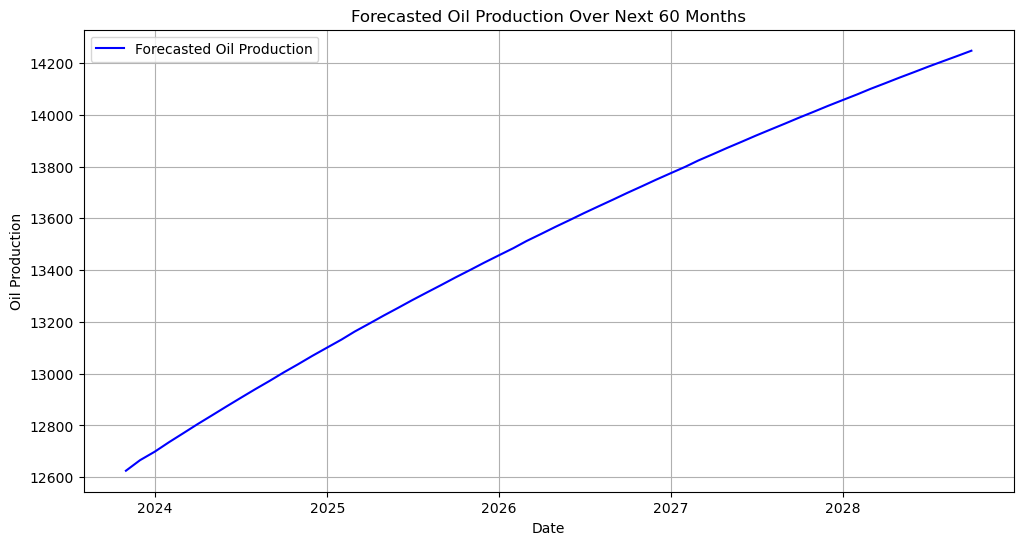

In [22]:
# Plotting the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Forecasted Oil Production'], label='Forecasted Oil Production', color='blue')
plt.title('Forecasted Oil Production Over Next {} Months'.format(n_months))
plt.xlabel('Date')
plt.ylabel('Oil Production')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Existing Code: Data Preparation
X = df_oil_prod.drop('OILPRODUS', axis=1)
y = df_oil_prod['OILPRODUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# New Code: Imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Existing Code: Model Training
# Model 1: ElasticNetCV from TPOT
elastic_net_model = ElasticNetCV(l1_ratio=0.15000000000000002, tol=0.1)
elastic_net_model.fit(X_train_imputed, y_train)
elastic_net_preds = elastic_net_model.predict(X_test_imputed)

# Model 2: ARIMA
from statsmodels.tsa.arima.model import ARIMA
order = (1, 1, 1)  # ARIMA order (p, d, q)
arima_model = ARIMA(y_train, order=order)
arima_fit = arima_model.fit()
arima_preds = arima_fit.forecast(steps=len(X_test)).values

# Model 3: LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_reshaped, y_train, epochs=50, verbose=0)
lstm_preds = lstm_model.predict(X_test_reshaped).flatten()


# Check for NaNs in y_test
if y_test.isna().any():
    print("NaNs found in y_test")

# Check for NaNs in model predictions
if np.isnan(elastic_net_preds).any():
    print("NaNs found in ElasticNet predictions")

if np.isnan(arima_preds).any():
    print("NaNs found in ARIMA predictions")

#if np.isnan(lstm_preds).any():
    #print("NaNs found in LSTM predictions")


# Ensemble Predictions
ensemble_preds = (elastic_net_preds + arima_preds ) / 2

# Evaluate the performance of the ensemble model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
mae_ensemble = mean_absolute_error(y_test, ensemble_preds)
rmse_ensemble = sqrt(mean_squared_error(y_test, ensemble_preds))


2/2 [==============================] - 0s 2ms/step


In [24]:
# Function to calculate metrics and confidence intervals
def calculate_metrics_and_ci(y_true, predictions, metric_function, num_iterations=1000, confidence_level=0.95):
    metrics = []
    for _ in range(num_iterations):
        # Bootstrap resampling
        indices = resample(np.arange(len(y_true)))
        y_true_resampled = y_true.iloc[indices]
        predictions_resampled = predictions[indices]

        # Calculate metric on resampled data
        metric_value = metric_function(y_true_resampled, predictions_resampled)
        metrics.append(metric_value)

    # Calculate confidence interval
    lower_bound = np.percentile(metrics, (1 - confidence_level) * 100 / 2)
    upper_bound = np.percentile(metrics, 100 - (1 - confidence_level) * 100 / 2)

    return np.mean(metrics), lower_bound, upper_bound

# Calculate metrics and confidence intervals for the ensemble
mae_ensemble_mean, mae_ensemble_lower, mae_ensemble_upper = calculate_metrics_and_ci(
    y_test, ensemble_preds, mean_absolute_error
)
rmse_ensemble_mean, rmse_ensemble_lower, rmse_ensemble_upper = calculate_metrics_and_ci(
    y_test, ensemble_preds, lambda x, y: sqrt(mean_squared_error(x, y))
)
mape_ensemble_mean, mape_ensemble_lower, mape_ensemble_upper = calculate_metrics_and_ci(
    y_test, ensemble_preds, lambda x, y: np.mean(np.abs((x - y) / x)) * 100
)

# Print evaluation metrics and confidence intervals for the ensemble
print(f'Ensemble Mean Absolute Percentage Error (MAPE): {mape_ensemble_mean:.2f}% [{mape_ensemble_lower:.2f}%, {mape_ensemble_upper:.2f}%]')


Ensemble Mean Absolute Percentage Error (MAPE): 16.33% [14.14%, 18.61%]
